## Домашнее задание №8

Взять датасет из google диска: https://drive.google.com/file/d/101fYypHh0u56KC5Lq2ywOCOdnh7WPho2/view?usp=sharing. Проверить гипотезу о том, в каком варианте теста (control/personalization) больше конверсия (converted) и значимо ли это отличие статистически.

In [23]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from scipy.stats import mannwhitneyu
import itertools

import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [1]:
!wget 'https://drive.google.com/uc?export=download&id=101fYypHh0u56KC5Lq2ywOCOdnh7WPho2' -O data.zip

--2022-09-11 04:05:36--  https://drive.google.com/uc?export=download&id=101fYypHh0u56KC5Lq2ywOCOdnh7WPho2
Resolving drive.google.com (drive.google.com)... 172.217.15.110, 2607:f8b0:4004:811::200e
Connecting to drive.google.com (drive.google.com)|172.217.15.110|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/em1dos0t8209lnais0q3otihdino4rhj/1662869100000/14165537686129864864/*/101fYypHh0u56KC5Lq2ywOCOdnh7WPho2?e=download&uuid=e10f4425-0aa4-48ea-bb9d-905a26c194ac [following]
--2022-09-11 04:05:37--  https://doc-14-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/em1dos0t8209lnais0q3otihdino4rhj/1662869100000/14165537686129864864/*/101fYypHh0u56KC5Lq2ywOCOdnh7WPho2?e=download&uuid=e10f4425-0aa4-48ea-bb9d-905a26c194ac
Resolving doc-14-94-docs.googleusercontent.com (doc-14-94-docs.googleusercontent.com)... 142.250.31.132, 2607:f8b0:4004:c

In [2]:
!unzip data.zip

Archive:  data.zip
  inflating: marketing description.txt  
  inflating: marketing_campaign.csv  
  inflating: subscribers.csv         
  inflating: users.csv               


In [14]:
marketing_campaign = pd.read_csv('marketing_campaign.csv')
marketing_campaign

,user_id,date_served,marketing_channel,variant,language_displayed,converted
0,a1000,1/1/18,House Ads,personalization,English,True
1,a1001,1/1/18,House Ads,personalization,English,True
2,a1002,1/1/18,House Ads,personalization,English,True
3,a1003,1/1/18,House Ads,personalization,English,True
4,a1004,1/1/18,House Ads,personalization,English,True
...,...,...,...,...,...,...
10032,a11032,1/17/18,Email,control,German,True
10033,a11033,1/17/18,Email,control,German,True
10034,a11034,1/5/18,Instagram,control,German,False
10035,a11035,1/17/18,Email,control,German,True


Удалим значения Nan из данных

In [15]:
marketing_campaign.dropna()

,user_id,date_served,marketing_channel,variant,language_displayed,converted
0,a1000,1/1/18,House Ads,personalization,English,True
1,a1001,1/1/18,House Ads,personalization,English,True
2,a1002,1/1/18,House Ads,personalization,English,True
3,a1003,1/1/18,House Ads,personalization,English,True
4,a1004,1/1/18,House Ads,personalization,English,True
...,...,...,...,...,...,...
10032,a11032,1/17/18,Email,control,German,True
10033,a11033,1/17/18,Email,control,German,True
10034,a11034,1/5/18,Instagram,control,German,False
10035,a11035,1/17/18,Email,control,German,True


In [6]:
marketing_campaign.variant.value_counts()

control            5091
personalization    4946
Name: variant, dtype: int64

In [7]:
marketing_campaign.converted.value_counts()

False    8946
True     1076
Name: converted, dtype: int64

Разметим столбец converted: True - 1, False - 0 

In [18]:
marketing_campaign['converted'] = marketing_campaign['converted'].replace({True: 1, False: 0})
marketing_campaign

,user_id,date_served,marketing_channel,variant,language_displayed,converted
0,1000,1/1/18,House Ads,personalization,English,1.0
1,1001,1/1/18,House Ads,personalization,English,1.0
2,1002,1/1/18,House Ads,personalization,English,1.0
3,1003,1/1/18,House Ads,personalization,English,1.0
4,1004,1/1/18,House Ads,personalization,English,1.0
...,...,...,...,...,...,...
10032,11032,1/17/18,Email,control,German,1.0
10033,11033,1/17/18,Email,control,German,1.0
10034,11034,1/5/18,Instagram,control,German,0.0
10035,11035,1/17/18,Email,control,German,1.0


Преобразуем колонку user_id

In [17]:
marketing_campaign['user_id'] = marketing_campaign['user_id'].str.replace(r'\D', '').astype(int)
marketing_campaign

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


,user_id,date_served,marketing_channel,variant,language_displayed,converted
0,1000,1/1/18,House Ads,personalization,English,1.0
1,1001,1/1/18,House Ads,personalization,English,1.0
2,1002,1/1/18,House Ads,personalization,English,1.0
3,1003,1/1/18,House Ads,personalization,English,1.0
4,1004,1/1/18,House Ads,personalization,English,1.0
...,...,...,...,...,...,...
10032,11032,1/17/18,Email,control,German,1.0
10033,11033,1/17/18,Email,control,German,1.0
10034,11034,1/5/18,Instagram,control,German,0.0
10035,11035,1/17/18,Email,control,German,1.0


Преобразуем колонку date_served

In [19]:
tmp = marketing_campaign['date_served'].str.split('/')
marketing_campaign['date_served'] = (tmp.str[2]+tmp.str[0]+tmp.str[1]).astype(float)
marketing_campaign

,user_id,date_served,marketing_channel,variant,language_displayed,converted
0,1000,1811.0,House Ads,personalization,English,1.0
1,1001,1811.0,House Ads,personalization,English,1.0
2,1002,1811.0,House Ads,personalization,English,1.0
3,1003,1811.0,House Ads,personalization,English,1.0
4,1004,1811.0,House Ads,personalization,English,1.0
...,...,...,...,...,...,...
10032,11032,18117.0,Email,control,German,1.0
10033,11033,18117.0,Email,control,German,1.0
10034,11034,1815.0,Instagram,control,German,0.0
10035,11035,18117.0,Email,control,German,1.0


In [20]:
marketing_campaign[marketing_campaign['variant'] == 'control'].describe()

,user_id,date_served,converted
count,5091.000000,5076.000000,5076.000000
mean,4514.883520,13141.227541,0.073089
std,1902.098695,7510.310996,0.260308
min,1055.000000,1811.000000,0.000000
25%,3193.500000,1818.000000,0.000000
50%,4466.000000,18115.000000,0.000000
75%,5738.500000,18123.000000,0.000000
max,11036.000000,18131.000000,1.000000


In [21]:
marketing_campaign[marketing_campaign['variant'] == 'personalization'].describe()

,user_id,date_served,converted
count,4946.000000,4945.000000,4946.000000
mean,7565.182774,13084.593731,0.142539
std,2931.790728,7533.556527,0.349638
min,1000.000000,1811.000000,0.000000
25%,7174.250000,1818.000000,0.000000
50%,8410.500000,18115.000000,0.000000
75%,9646.750000,18120.000000,0.000000
max,11019.000000,18131.000000,1.000000


In [24]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(marketing_campaign.drop(['converted'],axis=1), marketing_campaign['converted'], random_state=2) # X_test для А/В
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=2)# X_val - наш внутренний тест

In [25]:
# соберем простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


class OHEEncoderBin(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        B = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        self.columns = B[:1]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
    
        return X[self.columns]  


class NumericPower(BaseEstimator, TransformerMixin):
    def __init__(self, key, p=2):
        self.key = key
        self.columns = []
        self.p = p+1

    def fit(self, X, y=None):
        B = [self.key + str(i) for i in range(1, self.p)]
        self.columns = B + ['log']
        return self

    def transform(self, X):
        Xp = X.values.reshape(-1,1)
        for i in range(2, self.p):
            Xp = np.hstack([Xp,(X.values.reshape(-1,1) ** i).astype(float)])

        Xp = np.hstack([Xp, np.log(X.values.reshape(-1,1) + 1).astype(float)])    
        B = pd.DataFrame(data = Xp, index = X.index, columns =[self.columns] )
        return B[self.columns]

Проверяем состав и пропуски:

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5645 entries, 8202 to 858
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             5645 non-null   int64  
 1   date_served         5642 non-null   float64
 2   marketing_channel   5642 non-null   object 
 3   variant             5645 non-null   object 
 4   language_displayed  5645 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 264.6+ KB


Смотрим статистики на выбросы:

In [27]:
X_train.describe()

,user_id,date_served
count,5645.000000,5642.000000
mean,6023.735872,13065.299185
std,2888.896373,7541.640883
min,1000.000000,1811.000000
25%,3544.000000,1818.000000
50%,6029.000000,18115.000000
75%,8521.000000,18122.000000
max,11035.000000,18131.000000


In [28]:
X_train.head()

,user_id,date_served,marketing_channel,variant,language_displayed
8202,9202,18111.0,House Ads,personalization,English
6376,7376,1819.0,Facebook,personalization,English
2147,3147,18115.0,House Ads,control,English
5471,6471,18114.0,Facebook,control,English
5441,6441,18112.0,Instagram,control,English


In [29]:
X_train.columns

Index(['user_id', 'date_served', 'marketing_channel', 'variant',
       'language_displayed'],
      dtype='object')

Проверим визуально сходство распределений по всем подвыборкам:

In [30]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
for i in X_train.iloc[:,2:].select_dtypes(include=numerics).columns:
    sns.kdeplot(X_train.loc[y_train == 1,i], label='1 train')
    sns.kdeplot(X_train.loc[y_train == 0,i], ls='--', label='0 train')
    
    sns.kdeplot(X_val.loc[y_val == 1,i], label='1 val')
    sns.kdeplot(X_val.loc[y_val == 0,i], ls='--', label='0 val')
    
    sns.kdeplot(X_test.loc[y_test == 1,i], label='1 test')
    sns.kdeplot(X_test.loc[y_test == 0,i], ls='--', label='0 test')
    plt.title(i)
    plt.grid()
    plt.legend()
    plt.show()        

In [31]:
categorical_col =  ['marketing_channel', 'variant',  'language_displayed']

for i in categorical_col:
    print(i,' число уникальных значений: ', len(pd.unique(X_train[i])), 'уникальные значения', pd.unique(X_train[i]))

marketing_channel  число уникальных значений:  6 уникальные значения ['House Ads' 'Facebook' 'Instagram' 'Push' 'Email' nan]
variant  число уникальных значений:  2 уникальные значения ['personalization' 'control']
language_displayed  число уникальных значений:  4 уникальные значения ['English' 'German' 'Spanish' 'Arabic']


Проверим статистику сходства распределений :

In [32]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

for i in X_train.iloc[:,2:].select_dtypes(include=numerics).columns:
    tr_v_stats = mannwhitneyu(X_train.loc[y_train == 1, i], X_val.loc[y_val == 1, i])
    tr_test_stats = mannwhitneyu(X_train.loc[y_train == 1, i], X_test.loc[y_test == 1, i])
    print(i, ':', tr_v_stats[1], ':', tr_test_stats[1])

Собираем пайплайн обработки:

In [33]:
categorical_columns = ['marketing_channel', 'language_displayed']
continuous_columns = ['user_id','date_served']
categorical_bin_columns = ['variant']


from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

variant = Pipeline([
                ('selector', FeatureSelector(column='variant')),
                ('ohe', OHEEncoder(key='variant'))
            ])
variant.fit(X_train)
variant.transform(X_test).head()

,variant_control,variant_personalization
1711,0,1
1715,0,1
1415,0,1
793,0,1
3782,1,0


In [34]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

language_displayed = Pipeline([
                ('selector', FeatureSelector(column='language_displayed')),
                ('ohe', OHEEncoder(key='language_displayed'))
            ])
language_displayed.fit(X_train)
language_displayed.transform(X_test).head()

,language_displayed_Arabic,language_displayed_English,language_displayed_German,language_displayed_Spanish
1711,0,1,0,0
1715,0,1,0,0
1415,0,1,0,0
793,0,1,0,0
3782,0,1,0,0


In [35]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

marketing_channel = Pipeline([
                ('selector', FeatureSelector(column='marketing_channel')),
                ('ohe', OHEEncoder(key='marketing_channel'))
            ])
marketing_channel.fit(X_train)
marketing_channel.transform(X_test).head()

,marketing_channel_Email,marketing_channel_Facebook,marketing_channel_House Ads,marketing_channel_Instagram,marketing_channel_Push
1711,1,0,0,0,0
1715,0,1,0,0,0
1415,0,0,0,1,0
793,0,0,0,1,0
3782,0,1,0,0,0


In [36]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))


for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('Scale', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))


for bin_col in categorical_bin_columns:
    bin_transformer = Pipeline([
                ('selector', FeatureSelector(column=bin_col)),
                ('ohe', OHEEncoderBin(key=bin_col))
            ])
    final_transformers.append((bin_col, bin_transformer))

In [37]:
final_transformers

[('marketing_channel',
  Pipeline(steps=[('selector', FeatureSelector(column='marketing_channel')),
                  ('ohe', OHEEncoder(key='marketing_channel'))])),
 ('language_displayed',
  Pipeline(steps=[('selector', FeatureSelector(column='language_displayed')),
                  ('ohe', OHEEncoder(key='language_displayed'))])),
 ('user_id', Pipeline(steps=[('selector', NumberSelector(key='user_id')),
                  ('Scale', StandardScaler())])),
 ('date_served',
  Pipeline(steps=[('selector', NumberSelector(key='date_served')),
                  ('Scale', StandardScaler())])),
 ('variant', Pipeline(steps=[('selector', FeatureSelector(column='variant')),
                  ('ohe', OHEEncoderBin(key='variant'))]))]

Добавляем классификатор:

In [38]:
feats = FeatureUnion(final_transformers)

pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=42)),
])

In [39]:
# обучим наш пайплайн
pipeline.fit(X_train, y_train)

ValueError: ignored

In [ ]:
# наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_val)[:, 1]
preds[:10]

array([0.62, 0.3 , 0.01, 0.  , 0.04, 0.18, 0.05, 0.53, 0.15, 0.01])

КАлибруем модель:

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_val, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))


Best Threshold=0.320000, F-Score=0.599, Precision=0.571, Recall=0.630


Confusion matrix, without normalization
[[1281  191]
 [ 149  254]]


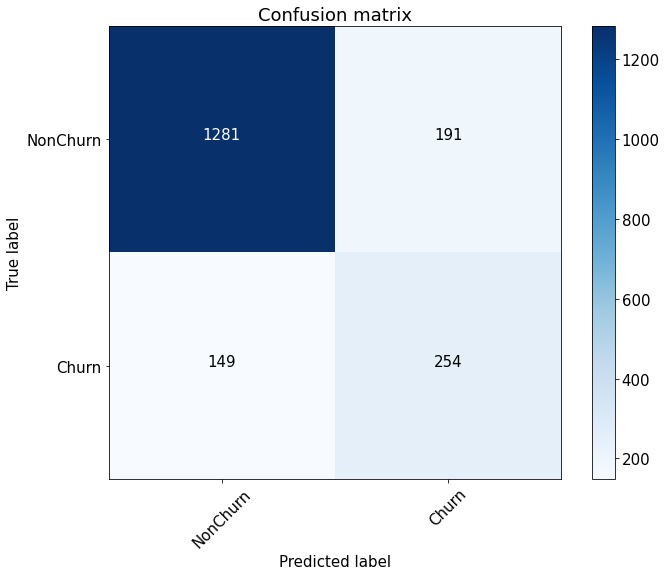

In [ ]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_val, preds >= thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
# Конверсия

TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

C0 = (TP + FN) / np.sum(cnf_matrix)
C0

0.21493333333333334



Начинаем A/B тест:

базовая конверсия 0.214<br>

Разбиваем тестовый набор на 2 группы: контрольную и рабочую:

In [ ]:
X_test.shape

(2500, 13)

In [ ]:
X_A, X_B, y_A, y_B = train_test_split(X_test, y_test, test_size=0.5, random_state=2)

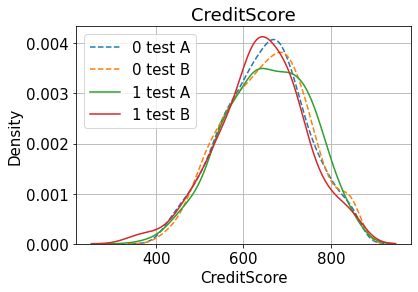

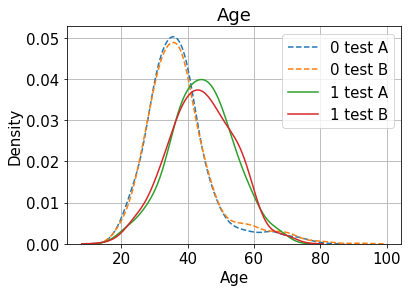

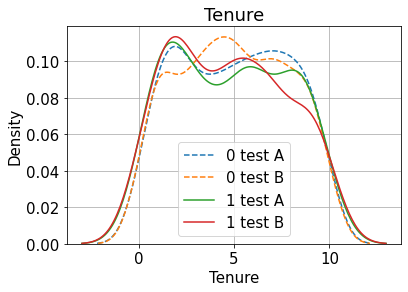

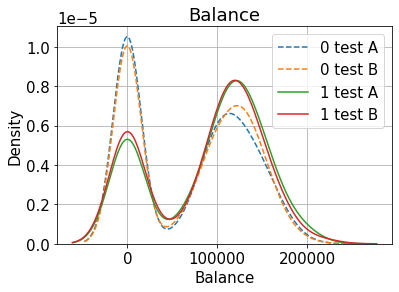

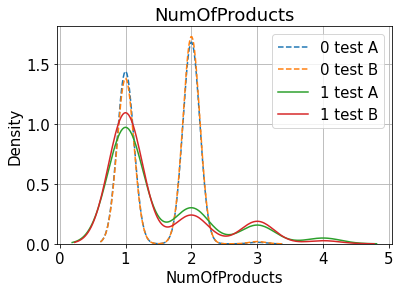

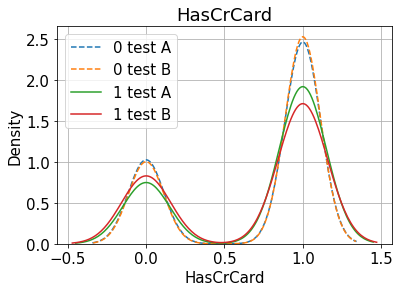

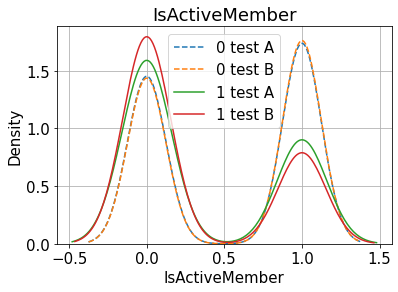

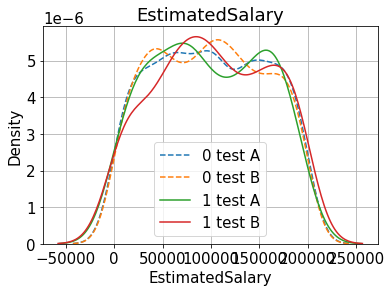

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
for i in X_train.iloc[:, 2:].select_dtypes(include=numerics).columns:
    sns.kdeplot(X_A.loc[y_A == 0,i], ls='--', label='0 test A')
    sns.kdeplot(X_B.loc[y_B == 0,i], ls='--', label='0 test B')
    
    sns.kdeplot(X_A.loc[y_A == 1,i], label='1 test A')
    sns.kdeplot(X_B.loc[y_B == 1,i], label='1 test B')
    plt.title(i)
    plt.grid()
    plt.legend()
    plt.show() 

Применяем модель к группе В:

In [ ]:
predsB = pipeline.predict_proba(X_B)[:, 1]
cnf_matrix = confusion_matrix(y_B, predsB > thresholds[ix])

TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]
print(cnf_matrix)

[[912  99]
 [ 89 150]]


In [ ]:
churn_ef = 0.5  # Снижение эффективности предсказания за счет не полного действия мер по борьбе с оттоком
C0_A = (np.sum(y_A)) / y_A.shape[0] # churn rate (коэффициента оттока клиентов) без ML
print(C0_A)
C1_MLB = (FN + (1-churn_ef) * TP) / np.sum(cnf_matrix) # churn rate (коэффициента оттока клиентов) при ML
print(C1_MLB)

0.1968
0.1312


In [ ]:
y_churnA = y_A

y_pred = (predsB > thresholds[ix])
ind_churn = np.where((y_pred != y_B) & (y_B == 1))
y_churnB = np.zeros(y_B.shape)
y_churnB[ind_churn] = 1


k1, n1 = np.sum(y_A), y_A.shape[0]
k2, n2 = np.sum(y_churnB), y_churnB.shape[0]
k1, k2, n1, n2

(246, 89.0, 1250, 1250)

In [ ]:
from statsmodels.stats import proportion

z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]), 
                                                 np.array([n1, n2]))

print(f'Results are z_score={z_score:.3f} pvalue={z_pvalue:.3f}')

Results are z_score=9.218 pvalue=0.000


In [ ]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]), 
                                                        np.array([n1, n2]))

print(f'Results are chisq={chisq:.3f} pvalue={pvalue:.3f}')

Results are chisq=84.964 pvalue=0.000
